#### Part2. 심화학습 - AI 사례 실습 
    chp11 - 비데, 정수기 렌탈고객 해지 예측 : (1) 데이터 전처리

In [37]:
# 환경설정 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import time 
import math 
from tqdm import tqdm
from datetime import datetime 
np.random.seed(42)

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   ## 시각화 음수 표현 가능 

In [38]:
# data load 
train_termination = pd.read_csv('data/bidet_w_disp_termination_train.csv')
test_termination = pd.read_csv('data/bidet_w_disp_termination_test.csv')
train_voc = pd.read_csv('data/bidet_w_disp_voc_train.csv')
test_voc = pd.read_csv('data/bidet_w_disp_voc_test.csv')

train_termination.shape, test_termination.shape, train_voc.shape, test_voc.shape 

((55000, 22), (5000, 22), (74529, 5), (6872, 5))

In [39]:
train_termination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            54990 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [40]:
train_voc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74529 entries, 0 to 74528
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           74529 non-null  object
 1   voc_type_cd  74529 non-null  int64 
 2   voc_type_nm  74529 non-null  object
 3   voc_cnt      74529 non-null  int64 
 4   day_cnt      74529 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.8+ MB


- train_termination의 w_disp_cnt에 결측치 존재 
- train_voc가 더 많은 row를 가짐 (1명당 복수의 voc)

In [41]:
pd.set_option('display.max_columns', None) 
train_termination.head(2)

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd
0,E1000001,Y,20170421,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.0,40393,43560,R09,R12
1,E1000002,N,20131203,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.0,34460,0,_,R06


In [42]:
train_voc.head(2)

,id,voc_type_cd,voc_type_nm,voc_cnt,day_cnt
0,E1000001,6,청구 수/미납,1,1
1,E1000002,9,해지,1,1


---
##### 데이터 결합

In [43]:
# train_termination과 train_voc의 결합을 위해  
## (1) 두 데이터의 형태가 다르므로, train_voc를 pivot_table을 사용하여 형태 변경 
train_voc_cnt = train_voc.pivot_table(index='id', columns='voc_type_nm', values='voc_cnt', 
                                      aggfunc='sum', fill_value=0)
train_day_cnt = train_voc.pivot_table(index='id', columns='voc_type_nm', values='day_cnt', 
                                      aggfunc='sum', fill_value=0)

test_voc_cnt = test_voc.pivot_table(index='id', columns='voc_type_nm', values='voc_cnt', 
                                      aggfunc='sum', fill_value=0)
test_day_cnt = test_voc.pivot_table(index='id', columns='voc_type_nm', values='day_cnt', 
                                      aggfunc='sum', fill_value=0)

train_voc_cnt

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
id,,,,,,,,,,,,,
E1000001,0,0,0,0,0,0,0,0,0,1,0,0,0
E1000002,0,0,0,0,0,0,0,0,0,0,0,1,0
E1000003,0,0,0,0,0,1,0,0,0,0,0,0,0
E1000004,1,0,0,0,0,0,0,0,0,0,1,0,0
E1000005,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
E1054996,0,0,0,0,0,0,0,0,0,0,1,0,0
E1054997,0,0,0,0,0,0,0,0,0,0,0,1,0
E1054998,0,0,0,0,0,2,0,0,0,0,0,0,0


In [44]:
## pivot_table 결과 오류여부 확인 (시행 전후가 일치하는지 비교)
print(train_voc['voc_cnt'].sum(), train_voc['day_cnt'].sum(), 
      test_voc['voc_cnt'].sum(), test_voc['day_cnt'].sum())

print(train_voc_cnt.sum().sum(), train_day_cnt.sum().sum(), 
      test_voc_cnt.sum().sum(), test_day_cnt.sum().sum())

90752 82858 8469 7702
90752 82858 8469 7702


In [45]:
## (2) 데이터 병합 
## concat으로 병합할때 : 인덱스가 동일해야 함 (인덱스 리셋, 기존 인덱스는 삭제)
train_voc_cnt = train_voc_cnt.reset_index(drop=True)
train_day_cnt = train_day_cnt.reset_index(drop=True)
test_voc_cnt = test_voc_cnt.reset_index(drop=True)
test_day_cnt = test_day_cnt.reset_index(drop=True)

display(train_voc_cnt.head(), train_day_cnt.head())

voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


voc_type_nm,AS,가입,개통,대리점문의,변경/조회,업무협조,이용,정보보호/언론보도,채널,청구 수/미납,품질,해지,혜택
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0


---
##### 데이터셋 결합

In [46]:
## 컬럼명 중복을 피하기 위해, 접두사 추가 
for col in train_voc_cnt.columns: 
    train_voc_cnt.rename(columns={col:'voc_cnt_'+col}, inplace=True)
    train_day_cnt.rename(columns={col:'day_cnt_'+col}, inplace=True)

for col in test_voc_cnt.columns: 
    test_voc_cnt.rename(columns={col:'voc_cnt_'+col}, inplace=True)
    test_day_cnt.rename(columns={col:'day_cnt_'+col}, inplace=True)

train_voc_cnt.columns, train_day_cnt.columns, test_voc_cnt.columns, test_day_cnt.columns 

(Index(['voc_cnt_AS', 'voc_cnt_가입', 'voc_cnt_개통', 'voc_cnt_대리점문의',
        'voc_cnt_변경/조회', 'voc_cnt_업무협조', 'voc_cnt_이용', 'voc_cnt_정보보호/언론보도',
        'voc_cnt_채널', 'voc_cnt_청구 수/미납', 'voc_cnt_품질', 'voc_cnt_해지',
        'voc_cnt_혜택'],
       dtype='object', name='voc_type_nm'),
 Index(['day_cnt_AS', 'day_cnt_가입', 'day_cnt_개통', 'day_cnt_대리점문의',
        'day_cnt_변경/조회', 'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_정보보호/언론보도',
        'day_cnt_채널', 'day_cnt_청구 수/미납', 'day_cnt_품질', 'day_cnt_해지',
        'day_cnt_혜택'],
       dtype='object', name='voc_type_nm'),
 Index(['voc_cnt_AS', 'voc_cnt_가입', 'voc_cnt_개통', 'voc_cnt_변경/조회',
        'voc_cnt_업무협조', 'voc_cnt_이용', 'voc_cnt_정보보호/언론보도', 'voc_cnt_채널',
        'voc_cnt_청구 수/미납', 'voc_cnt_품질', 'voc_cnt_해지', 'voc_cnt_혜택'],
       dtype='object', name='voc_type_nm'),
 Index(['day_cnt_AS', 'day_cnt_가입', 'day_cnt_개통', 'day_cnt_변경/조회',
        'day_cnt_업무협조', 'day_cnt_이용', 'day_cnt_정보보호/언론보도', 'day_cnt_채널',
        'day_cnt_청구 수/미납', 'day_cnt_품질', 'day_cn

In [47]:
## 결합 : train_termination + train_voc_cnt + train_day_cnt, test_termination + test_voc_cnt + test_day_cnt 
train_data = pd.concat([train_termination, train_voc_cnt, train_day_cnt], axis=1)  
test_data = pd.concat([test_termination, test_voc_cnt, test_day_cnt], axis=1)  

train_data.shape, test_data.shape

((55000, 48), (5000, 46))

In [48]:
## test 데이터에는 2개 컬럼('voc_cnt_대리점문의','day_cnt_대리점문의') 컬럼이 존재하지 않음 
## 크게 중요하지 않은 데이터로 판단, 삭제 
train_data.drop(['voc_cnt_대리점문의','day_cnt_대리점문의'], axis=1, inplace=True)
train_data.shape, test_data.shape

((55000, 46), (5000, 46))

---
##### 결측치 처리

In [49]:
# 결측치 확인 
train_data.isnull().sum().sum(), test_data.isnull().sum().sum()

(10, 0)

In [50]:
# train_data에 10개의 결측치 존재 -> 상세확인 
train_data.isnull().sum()

id                       0
status                   0
new_date                 0
bidet_cnt                0
w_disp_cnt              10
cust_cd                  0
sex_cd                   0
w_disp_yn                0
bidet_yn                 0
comb_prod_yn             0
bidet_comb_yn            0
w_disp_comb_yn           0
bidet_trmn_eperd_cd      0
w_disp_trmn_eperd_cd     0
w_disp_trmn_why_cd       0
bidet_trmn_why_cd        0
npay_yn                  0
3m_avg_bill_amt          0
3m_bidet_avg_amt         0
3m_w_disp_avg_amt        0
w_disp_engt_rperd_cd     0
bidet_engt_rperd_cd      0
voc_cnt_AS               0
voc_cnt_가입               0
voc_cnt_개통               0
voc_cnt_변경/조회            0
voc_cnt_업무협조             0
voc_cnt_이용               0
voc_cnt_정보보호/언론보도        0
voc_cnt_채널               0
voc_cnt_청구 수/미납          0
voc_cnt_품질               0
voc_cnt_해지               0
voc_cnt_혜택               0
day_cnt_AS               0
day_cnt_가입               0
day_cnt_개통               0
d

In [51]:
train_data[train_data['w_disp_cnt'].isnull()]

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택
50,E1000051,Y,20200515,0,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,177563.001,29793,74708,R34,P05,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
51,E1000052,N,20150416,0,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,83873.001,16792,38106,P27,R11,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
52,E1000053,N,20121022,1,NaN,10001,M,N,Y,N,N,N,_,_,_,_,N,50318.001,16772,0,_,R01,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
53,E1000054,N,20160210,2,NaN,10001,F,N,Y,N,N,N,_,_,_,_,N,7809.000,2603,0,_,P23,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,0,1,0
54,E1000055,N,20161028,1,NaN,10001,M,N,Y,N,N,N,_,_,_,_,Y,12582.000,4124,0,_,P15,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
55,E1000056,Y,20130515,3,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,318153.999,35497,32666,P34,R11,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
56,E1000057,Y,20200716,1,NaN,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,400389.000,32356,54992,R21,R09,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
57,E1000058,Y,20190209,5,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,337518.000,46443,46200,R19,R13,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
58,E1000059,N,20171023,2,NaN,10001,F,N,Y,Y,Y,Y,_,_,_,_,N,98709.000,32540,0,_,P03,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
59,E1000060,Y,20180927,1,NaN,10001,M,Y,Y,Y,Y,Y,_,_,_,_,N,367350.000,33403,50600,R14,R08,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


count    54990.000000
mean         0.737207
std          1.137186
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        125.000000
Name: w_disp_cnt, dtype: float64

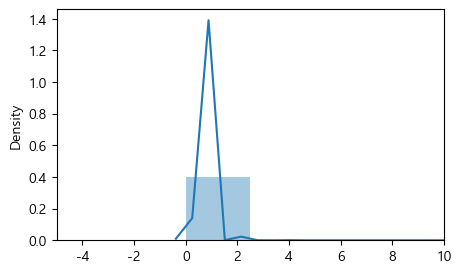

In [52]:
## 'w_disp_cnt'의 분포 확인 
display(train_data['w_disp_cnt'].describe())

plt.figure(figsize=(5,3))
sns.distplot(x=train_data['w_disp_cnt'])
plt.xlim(-5,10)
plt.show()

In [53]:
## w_disp_cnt의 대부분의값은 1 --> 결측치를 전부 median값(=1)로 대체함 
train_data['w_disp_cnt'].fillna(1, inplace=True)
train_data.isnull().sum().sum()

0

---
##### 데이터 타입 변경

In [54]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    55000 non-null  object 
 1   status                55000 non-null  object 
 2   new_date              55000 non-null  int64  
 3   bidet_cnt             55000 non-null  int64  
 4   w_disp_cnt            55000 non-null  float64
 5   cust_cd               55000 non-null  int64  
 6   sex_cd                55000 non-null  object 
 7   w_disp_yn             55000 non-null  object 
 8   bidet_yn              55000 non-null  object 
 9   comb_prod_yn          55000 non-null  object 
 10  bidet_comb_yn         55000 non-null  object 
 11  w_disp_comb_yn        55000 non-null  object 
 12  bidet_trmn_eperd_cd   55000 non-null  object 
 13  w_disp_trmn_eperd_cd  55000 non-null  object 
 14  w_disp_trmn_why_cd    55000 non-null  object 
 15  bidet_trmn_why_cd  

In [55]:
## 'new_date'는 날짜, 'cust_cd'는 문자형인데 잘못 인식된 듯 
train_data[['new_date', 'cust_cd']].head()

,new_date,cust_cd
0,20170421,10001
1,20131203,10001
2,20170731,10001
3,20090930,10001
4,20151121,10001


In [56]:
## 'new_date' --> datetime 
train_data['new_date'] = pd.to_datetime(train_data['new_date'], format='%Y%m%d')
test_data['new_date'] = pd.to_datetime(test_data['new_date'], format='%Y%m%d')

print("new_date's type =", train_data['new_date'].dtype)

new_date's type = datetime64[ns]


In [57]:
## 'cust_cd' --> object 
train_data['cust_cd'] = train_data['cust_cd'].astype('object')
test_data['cust_cd'] = test_data['cust_cd'].astype('object')

print("cust_cd's type = ", train_data['cust_cd'].dtype)

cust_cd's type =  object


---
##### 파생변수 추가 

In [58]:
# 가입기간 = 데이터 추출일자 - 가입일자 
## train_data의 추출일자는 2020/08/31일, test_data의 추출일자는 2020/09/30일임 

train_data['join_period'] = (datetime(2020,8,31,0,0) - train_data['new_date']).dt.days 
test_data['join_period'] = (datetime(2020,9,30,0,0) - test_data['new_date']).dt.days 

display(train_data['join_period'].head())
display(test_data['join_period'].head())

0    1228
1    2463
2    1127
3    3988
4    1745
Name: join_period, dtype: int64

0    2150
1    2141
2    2235
3    1286
4    1170
Name: join_period, dtype: int64

In [59]:
'''
*해지경과 코드 (bidet_trmn_eperd_cd, w_disp_trmn_eperd_cd)
(1) 0 : 당월 해지 
(2) Rxx : 해지후 xx개월 경과 
(3) _ : 해지하지 않음 
'''
train_data['bidet_trmn_eperd_cd'].value_counts().index

Index(['_', 'R37', '0', 'R01', 'R02', 'R08', 'R04', 'R11', 'R03', 'R07', 'R12',
       'R05', 'R09', 'R06', 'R10', 'R31', 'R18', 'R23', 'R32', 'R19', 'R14',
       'R13', 'R20', 'R16', 'R24', 'R25', 'R33', 'R15', 'R36', 'R35', 'R17',
       'R26', 'R21', 'R30', 'R34', 'R22', 'R28', 'R27', 'R29'],
      dtype='object', name='bidet_trmn_eperd_cd')

In [60]:
train_data['w_disp_trmn_eperd_cd'].value_counts().index

Index(['_', 'R37', '0', 'R01', 'R02', 'R06', 'R05', 'R04', 'R03', 'R09', 'R28',
       'R18', 'R11', 'R15', 'R07', 'R12', 'R10', 'R25', 'R14', 'R17', 'R08',
       'R26', 'R19', 'R16', 'R27', 'R21', 'R35', 'R24', 'R23', 'R13', 'R30',
       'R29', 'R32', 'R20', 'R22', 'R31', 'R34', 'R36', 'R33'],
      dtype='object', name='w_disp_trmn_eperd_cd')

In [61]:
# 해지경과코드를 실제 해지후 경과기간(0~37개월)로 변경 
## 해지하지 않은 경우(_)는 38로 변경  *해지후 매우 오래 경과된 것으로, 즉 최대값 37개월 보다 큰 값으로 변경함 

def RcdtoInt(Rcd): 
    if Rcd == '_': 
        return 38 
    elif Rcd == '0':
        return 0 
    else: 
        return int(Rcd[1:3])   ## Rxx 부분에서 개월수를 나타내는 xx 부분만 추출 


tepered_cols = ['bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd']  ## 변환대상 컬럼 

for column in tepered_cols: 
    new_column = column.replace('_trmn_eperd_cd', '_teperd')
    train_data[new_column] = train_data[column].apply(RcdtoInt)
    test_data[new_column] = test_data[column].apply(RcdtoInt)

In [62]:
train_data.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,bidet_teperd,w_disp_teperd
0,E1000001,Y,2017-04-21,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1228,38,38
1,E1000002,N,2013-12-03,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2463,38,38
2,E1000003,N,2017-07-31,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1127,38,38
3,E1000004,Y,2009-09-30,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3988,38,38
4,E1000005,N,2015-11-21,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1745,38,38


In [63]:
'''
*약정 잔여기간 코드 (w_disp_engt_rperd_cd, bidet_engt_rperd_cd)
(1) 0 : 약정만료 당월 
(2) Pxx : 약정만료 후 xx개월 경과 
(3) Rxx : 약정만료까지 잔여 개월수 
(4) | : 이미 해지
(5) _ : 무약정 
'''
print(train_data['w_disp_engt_rperd_cd'].value_counts().index) 
print('-'*100)
print(train_data['bidet_engt_rperd_cd'].value_counts().index) 

Index(['_', 'P37', 'R01', 'R36', '0', 'R35', 'R12', 'P01', 'R10', 'R11', 'R13',
       'R08', 'R27', 'R09', 'R20', 'R24', 'R34', 'R22', 'R18', 'R33', 'R21',
       'P02', 'R15', 'R25', 'R16', 'R28', 'R17', 'R14', 'R29', 'R32', 'R26',
       'R02', 'P04', 'R23', 'R06', 'R19', 'R30', 'R04', 'P03', 'R31', 'R07',
       'R03', 'R05', 'P05', 'P12', 'P06', 'P14', 'P07', 'P08', 'P09', 'P13',
       'P11', 'P24', 'P10', 'P36', 'P25', 'P28', 'P16', 'P35', 'P15', 'P34',
       'P27', 'P32', 'P26', 'P30', 'P19', 'P21', 'P33', 'P17', 'P22', 'P31',
       'P18', 'P23', 'P20', 'P29', '|', 'R37'],
      dtype='object', name='w_disp_engt_rperd_cd')
----------------------------------------------------------------------------------------------------
Index(['_', 'R12', 'R07', 'R06', 'R11', 'R10', 'R09', 'R13', 'R24', 'R08',
       'R23', 'R14', 'R22', 'R05', 'R15', 'R04', 'R21', 'R02', 'R01', 'R30',
       'R20', 'R18', 'R16', 'R03', 'R19', 'R29', 'R17', '0', 'R28', 'R25',
       'P37', 'R26', 'R27', 'P0

In [64]:
## 약정잔여 코드를 실제 약정까지 경과/남은 기간으로 변경 
def RPcdtoInt(RPcd): 
    if RPcd == '_' : 
        return int(38)
    elif RPcd == '0' :                 ## 0이 문자열임에 주의 
        return int(0)
    elif RPcd == '|':
        return int(0)
    elif RPcd[0] == 'P':
        return int(RPcd[1:3])
    else: 
        return -int(RPcd[1:3])         ## Rxx인 경우 : 약정까지 미경과 이므로 마이너스 개월수로 표현 

In [65]:
erperd_cols = ['w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']

for column in erperd_cols: 
    new_column = column.replace('_engt_rperd_cd', '_erperd')   
    train_data[new_column] = train_data[column].apply(RPcdtoInt)
    test_data[new_column] = test_data[column].apply(RPcdtoInt)

In [66]:
train_data.head()

,id,status,new_date,bidet_cnt,w_disp_cnt,cust_cd,sex_cd,w_disp_yn,bidet_yn,comb_prod_yn,bidet_comb_yn,w_disp_comb_yn,bidet_trmn_eperd_cd,w_disp_trmn_eperd_cd,w_disp_trmn_why_cd,bidet_trmn_why_cd,npay_yn,3m_avg_bill_amt,3m_bidet_avg_amt,3m_w_disp_avg_amt,w_disp_engt_rperd_cd,bidet_engt_rperd_cd,voc_cnt_AS,voc_cnt_가입,voc_cnt_개통,voc_cnt_변경/조회,voc_cnt_업무협조,voc_cnt_이용,voc_cnt_정보보호/언론보도,voc_cnt_채널,voc_cnt_청구 수/미납,voc_cnt_품질,voc_cnt_해지,voc_cnt_혜택,day_cnt_AS,day_cnt_가입,day_cnt_개통,day_cnt_변경/조회,day_cnt_업무협조,day_cnt_이용,day_cnt_정보보호/언론보도,day_cnt_채널,day_cnt_청구 수/미납,day_cnt_품질,day_cnt_해지,day_cnt_혜택,join_period,bidet_teperd,w_disp_teperd,w_disp_erperd,bidet_erperd
0,E1000001,Y,2017-04-21,1,0.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,381711.000,40393,43560,R09,R12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1228,38,38,-9,-12
1,E1000002,N,2013-12-03,2,0.0,10001,M,N,Y,N,N,N,_,_,_,_,N,110100.000,34460,0,_,R06,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2463,38,38,38,-6
2,E1000003,N,2017-07-31,1,1.0,10001,M,Y,N,Y,Y,Y,_,_,_,_,N,90000.000,0,28600,0,_,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1127,38,38,0,38
3,E1000004,Y,2009-09-30,4,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,Y,218303.001,34747,55000,P36,R11,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,3988,38,38,36,-11
4,E1000005,N,2015-11-21,1,1.0,10001,F,Y,Y,Y,Y,Y,_,_,_,_,N,310095.999,59856,54082,R27,R22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1745,38,38,-27,-22


---
##### 불필요한 컬럼 삭제 

In [67]:
## 일괄삭제를 위해 리스트 생성
del_cols = []

In [68]:
## id 불필요 
del_cols.append('id')
del_cols

['id']

In [69]:
## numeric columns : 0이 90%를 넘는 변수는 삭제 대상
## object columns : 특정 카테고리가 90%를 넘는 변수는 삭제 대상

num_cols = train_data.select_dtypes(['int64', 'float64']).columns
obj_cols = train_data.select_dtypes('object').columns
#print(num_cols, '\n', obj_cols)

for column in num_cols:
    zero_ratio = (train_data[column] == 0).sum() / train_data.shape[0]
    if zero_ratio > 0.9:
        print(f"{column}: {zero_ratio:.2%}")  
        del_cols.append(column)

print('-'*100 )

for column in obj_cols:
    top_category_ratio = train_data[column].value_counts(normalize=True).max()
    if top_category_ratio > 0.9:
        print(f"{column}: {top_category_ratio:.2%}")
        del_cols.append(column)

voc_cnt_AS: 96.51%
voc_cnt_개통: 98.38%
voc_cnt_정보보호/언론보도: 99.37%
voc_cnt_채널: 93.43%
voc_cnt_품질: 90.00%
voc_cnt_혜택: 96.72%
day_cnt_AS: 96.51%
day_cnt_개통: 98.38%
day_cnt_정보보호/언론보도: 99.37%
day_cnt_채널: 93.43%
day_cnt_품질: 90.00%
day_cnt_혜택: 96.72%
----------------------------------------------------------------------------------------------------
cust_cd: 97.60%
bidet_trmn_eperd_cd: 92.67%
w_disp_trmn_eperd_cd: 93.78%
w_disp_trmn_why_cd: 94.20%
bidet_trmn_why_cd: 92.94%


In [70]:
## 파생변수로 대체된 컬럼들 삭제대상 추가 
del_cols = del_cols + ['new_date', 'w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']
print(del_cols)

['id', 'voc_cnt_AS', 'voc_cnt_개통', 'voc_cnt_정보보호/언론보도', 'voc_cnt_채널', 'voc_cnt_품질', 'voc_cnt_혜택', 'day_cnt_AS', 'day_cnt_개통', 'day_cnt_정보보호/언론보도', 'day_cnt_채널', 'day_cnt_품질', 'day_cnt_혜택', 'cust_cd', 'bidet_trmn_eperd_cd', 'w_disp_trmn_eperd_cd', 'w_disp_trmn_why_cd', 'bidet_trmn_why_cd', 'new_date', 'w_disp_engt_rperd_cd', 'bidet_engt_rperd_cd']


In [71]:
## del_cols의 변수들 일괄삭제 
train_data.drop(del_cols, axis=1, inplace=True)
test_data.drop(del_cols, axis=1, inplace=True)

train_data.shape, test_data.shape

((55000, 30), (5000, 30))

In [ ]:
# 최종 데이터프레임 저장 
train_data.to_parquet("data/train_data.parquet", engine='pyarrow', compression='gzip', index=False)
test_data.to_parquet("data/test_data.parquet", engine='pyarrow', compression='gzip', index=False)